In [1]:
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
import copy
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from collections import deque
from tqdm import tqdm
import random

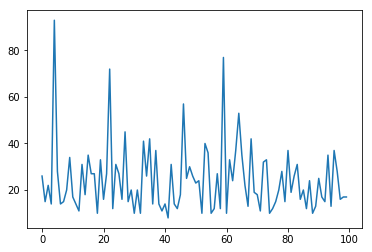

24.26


In [2]:
%matplotlib inline
env = gym.make('CartPole-v0')
episodes = 100
remember = []
episode_numbers = []
for i in range(episodes):
    episode_numbers.append(i)
    observed = env.reset()
    done = False
    Return = 0
    while(done!=True):
        action = np.random.randint(env.action_space.n)
        observed, reward, done, info = env.step(action)
        Return += reward
    remember.append(Return)
plt.plot(episode_numbers, remember)
plt.show()
print(np.mean(np.array(remember)))

In [6]:
np.random.randint(100)

74

In [3]:
class DQN:
    def __init__(self, layer_sizes, lr, sync_freq, exp_replay_size, seed=None):
        if seed is None:
            seed = np.random.randint(100)
        torch.manual_seed(seed)
        self.q_net = self.build_nn(layer_sizes)
        self.target_net = copy.deepcopy(self.q_net)
        self.q_net.cuda()
        self.target_net.cuda()
        self.loss_fn = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=lr)
        self.network_sync_freq = sync_freq
        self.network_sync_counter = 0
        self.gamma = torch.tensor(0.95).float().cuda()
        self.experience_replay = deque(maxlen = exp_replay_size) 
    
    def build_nn(self, layer_sizes):
        
        assert len(layer_sizes) > 1
        layers = []
        for index in range(len(layer_sizes)-1):
            linear = nn.Linear(layer_sizes[index], layer_sizes[index+1])
            act =    nn.Tanh() if index < len(layer_sizes)-2 else nn.Identity()
            layers += (linear, act)
        return nn.Sequential(*layers)
    
    def get_action(self, state, action_space_len, epsilon):
        with torch.no_grad():
            Qp = self.q_net(torch.from_numpy(state).float().cuda())
        Q,A = torch.max(Qp, axis=0)
        A = A if torch.rand(1,).item() > epsilon else torch.randint(0,action_space_len,(1,))
        return A
    
    def get_q_next(self, state):
        with torch.no_grad():
            qp = self.target_net(state)
        q,_ = torch.max(qp, axis=1)    
        return q
    
    def collect_experience(self, experience):
        self.experience_replay.append(experience)
        return
    
    def sample_from_experience(self, sample_size):
        if(len(self.experience_replay) < sample_size):
            sample_size = len(self.experience_replay)   
        sample = random.sample(self.experience_replay, sample_size)
        s = torch.tensor([exp[0] for exp in sample]).float()
        a = torch.tensor([exp[1] for exp in sample]).float()
        rn = torch.tensor([exp[2] for exp in sample]).float()
        sn = torch.tensor([exp[3] for exp in sample]).float()   
        return s, a, rn, sn
    
    def train(self, batch_size ):
        s, a, rn, sn = self.sample_from_experience( sample_size = batch_size)
        if(self.network_sync_counter == self.network_sync_freq):
            self.target_net.load_state_dict(self.q_net.state_dict())
            self.network_sync_counter = 0
        
        qp = self.q_net(s.cuda())
        pred_return, _ = torch.max(qp, axis=1)
        
        q_next = self.get_q_next(sn.cuda())
        target_return = rn.cuda() + self.gamma * q_next
        
        loss = self.loss_fn(pred_return, target_return)
        self.optimizer.zero_grad()
        loss.backward(retain_graph=True)
        self.optimizer.step()
        
        self.network_sync_counter += 1       
        return loss.item()

In [4]:
env = gym.make('CartPole-v0')
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
exp_replay_size = 256
agent = DQN(seed = 1423, layer_sizes = [input_dim, 64, output_dim], lr = 1e-4, sync_freq = 5, exp_replay_size = exp_replay_size)

# initiliaze experiance replay      
index = 0
for i in range(exp_replay_size):
    obs = env.reset()
    done = False
    while(done != True):
        A = agent.get_action(obs, env.action_space.n, epsilon=1)
        obs_next, reward, done, _ = env.step(A.item())
        agent.collect_experience([obs, A.item(), reward, obs_next])
        obs = obs_next
        index += 1
        if( index > exp_replay_size ):
            break
            
# Main training loop
losses_list, reward_list, episode_len_list, epsilon_list  = [], [], [], []
index = 128
episodes = 10000
epsilon = 1
episode_numbers = []

for i in tqdm(range(episodes)):
    episode_numbers.append(i)
    obs, done, losses, ep_len, rew = env.reset(), False, 0, 0, 0
    while(done != True):
        ep_len += 1 
        A = agent.get_action(obs, env.action_space.n, epsilon)
        obs_next, reward, done, _ = env.step(A.item())
        agent.collect_experience([obs, A.item(), reward, obs_next])
       
        obs = obs_next
        rew  += reward
        index += 1
        
        if(index > 128):
            index = 0
            for j in range(4):
                loss = agent.train(batch_size=16)
                losses += loss      
    if epsilon > 0.05 :
        epsilon -= (1 / 5000)
    
    losses_list.append(losses/ep_len), reward_list.append(rew), episode_len_list.append(ep_len), epsilon_list.append(epsilon)

100%|████████████████████████████████| 10000/10000 [29:59<00:00,  3.26it/s]


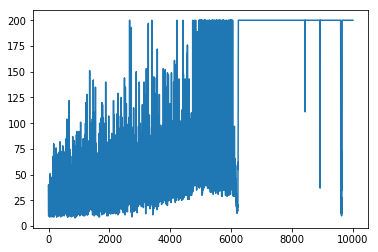

In [8]:
plt.plot(episode_numbers, reward_list)
plt.show()